In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Create sparse graph data with fallback for empty edge_index
def create_sparse_graph_data(features, labels, threshold=0.8):
    x = torch.tensor(features.values, dtype=torch.float)
    num_nodes = features.shape[0]
    edge_index = []

    # Create edges based on similarity threshold
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            similarity = F.cosine_similarity(
                x[i].unsqueeze(0), x[j].unsqueeze(0), dim=1
            ).item()
            if similarity > threshold:
                edge_index.append([i, j])
                edge_index.append([j, i])

    edge_index = torch.tensor(edge_index).t().contiguous() if edge_index else torch.empty((2, 0), dtype=torch.long)

    # Fallback to fully connected graph if no edges exist
    if edge_index.numel() == 0:
        print("No edges created; falling back to fully connected graph.")
        edge_index = torch.tensor([
            [i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j
        ]).t().contiguous()

    y = torch.tensor(labels.values, dtype=torch.long)
    return Data(x=x, edge_index=edge_index, y=y)

# Define GAT model
class GAT(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, num_heads=2):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_features, hidden_dim, heads=num_heads, concat=True)
        self.conv2 = GATConv(hidden_dim * num_heads, num_classes, heads=1, concat=False)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Compute weighted loss
def weighted_loss(out, y, train_mask):
    class_counts = torch.bincount(y[train_mask])
    class_weights = 1.0 / (class_counts + 1e-5)
    class_weights = class_weights / class_weights.sum()
    loss = F.nll_loss(out[train_mask], y[train_mask], weight=class_weights)
    return loss

# Train and evaluate GNN
def train_and_evaluate_gnn(data, train_mask, test_mask, epochs=100, learning_rate=0.01):
    model = GAT(num_features=data.num_features, hidden_dim=32, num_classes=len(data.y.unique()))
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    accuracy_list = []
    loss_list = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = weighted_loss(out, data.y, train_mask)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0 or epoch == epochs - 1:
            model.eval()
            with torch.no_grad():
                pred = model(data).argmax(dim=1)
                correct = pred[test_mask] == data.y[test_mask]
                accuracy = int(correct.sum()) / int(test_mask.sum())
                accuracy_list.append(accuracy)
                loss_list.append(loss.item())
                print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Test Accuracy: {accuracy:.4f}")

    return accuracy_list, loss_list

# Process dataset
def process_dataset(file_path, target_column, similarity_threshold=0.8):
    df = pd.read_csv(file_path)
    X = df.drop(columns=[target_column])  # Exclude target column
    y = df[target_column]

    # Handle non-numeric columns by encoding them
    if X.select_dtypes(include=["object"]).shape[1] > 0:
        X = X.apply(pd.to_numeric, errors='coerce')

    # Handle missing values by filling with the mean
    X = X.fillna(X.mean())

    # Normalize features
    X = (X - X.mean()) / X.std()

    # Convert target labels to numeric
    y = pd.factorize(y)[0]

    # Split data into training and testing sets
    train_indices, test_indices = train_test_split(np.arange(len(y)), test_size=0.3, stratify=y, random_state=42)
    train_mask = torch.zeros(len(y), dtype=torch.bool)
    test_mask = torch.zeros(len(y), dtype=torch.bool)
    train_mask[train_indices] = True
    test_mask[test_indices] = True

    # Create sparse graph data
    data = create_sparse_graph_data(X, pd.Series(y), threshold=similarity_threshold)
    return data, train_mask, test_mask

Results saved to model_results.csv


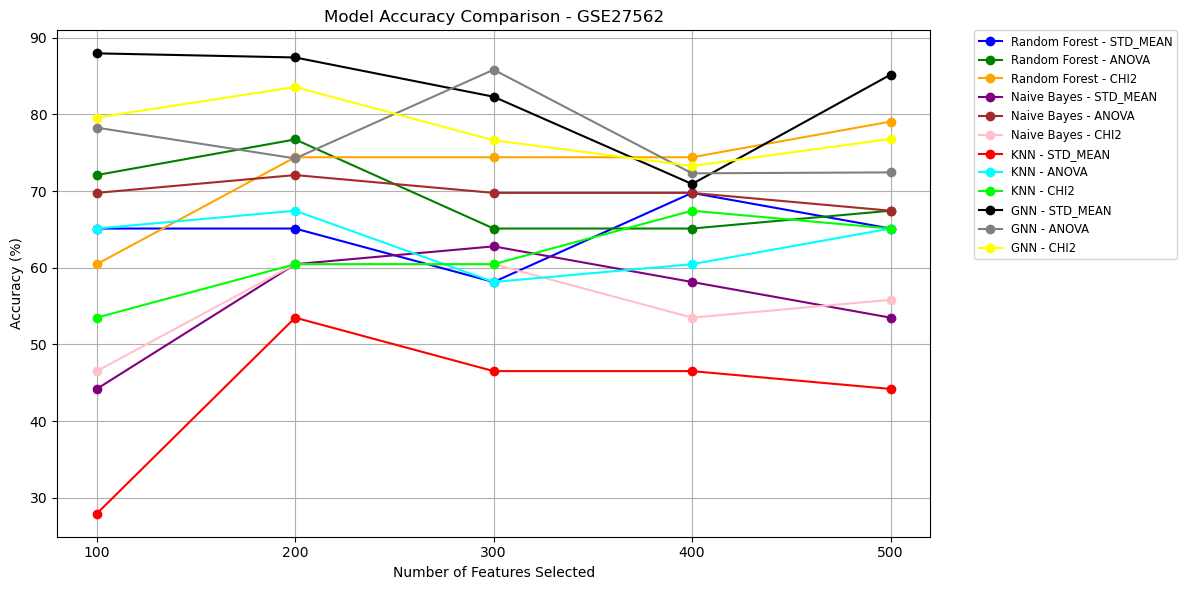

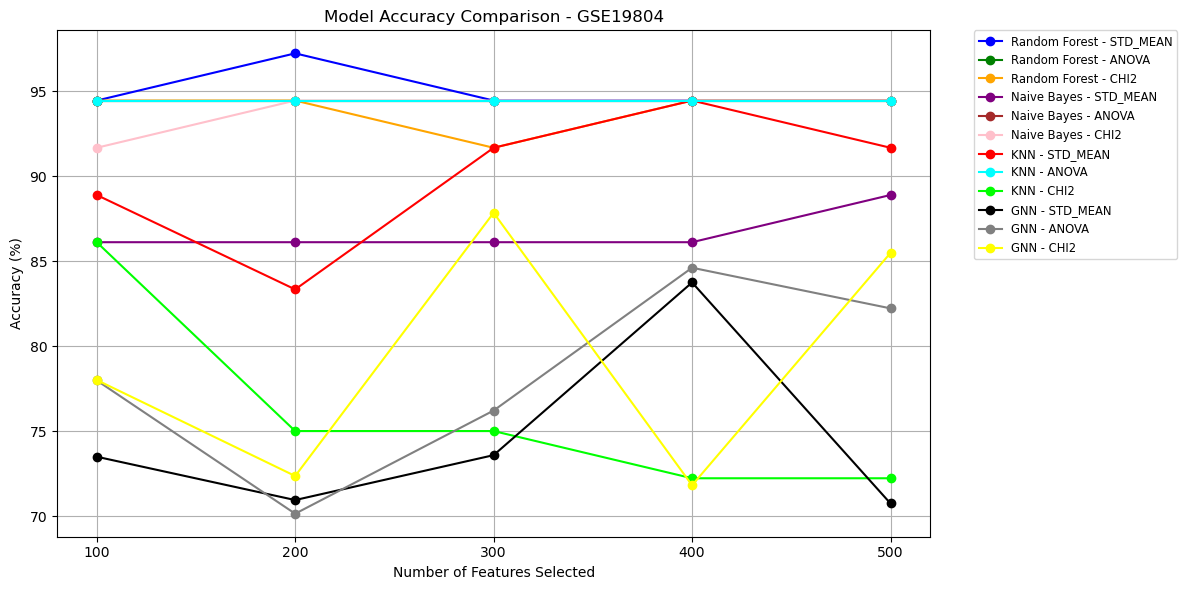

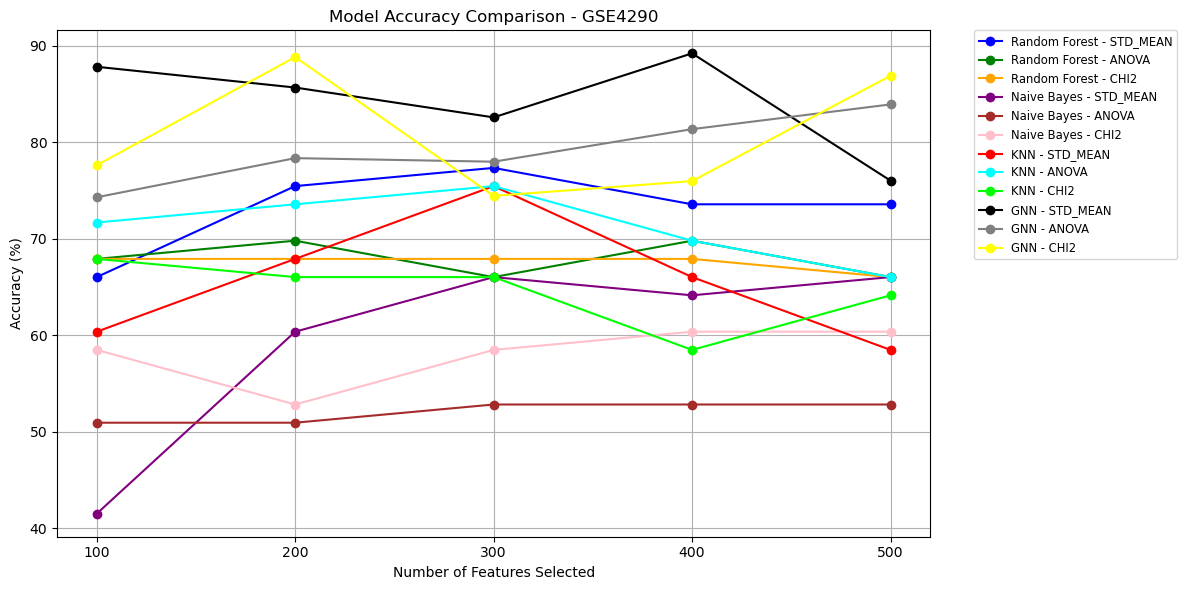

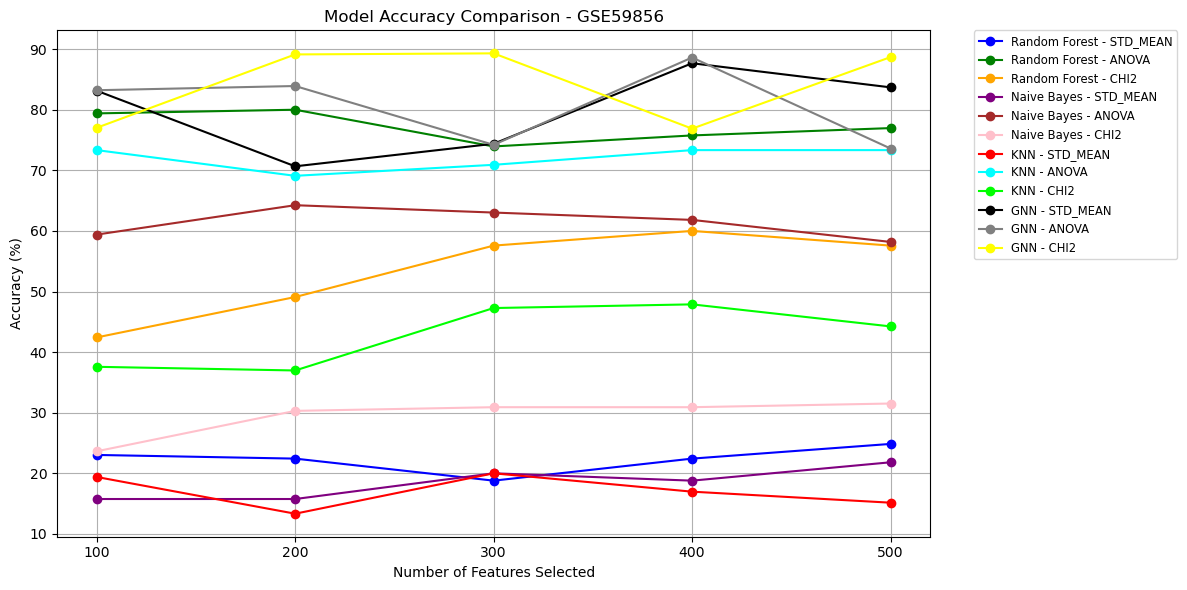

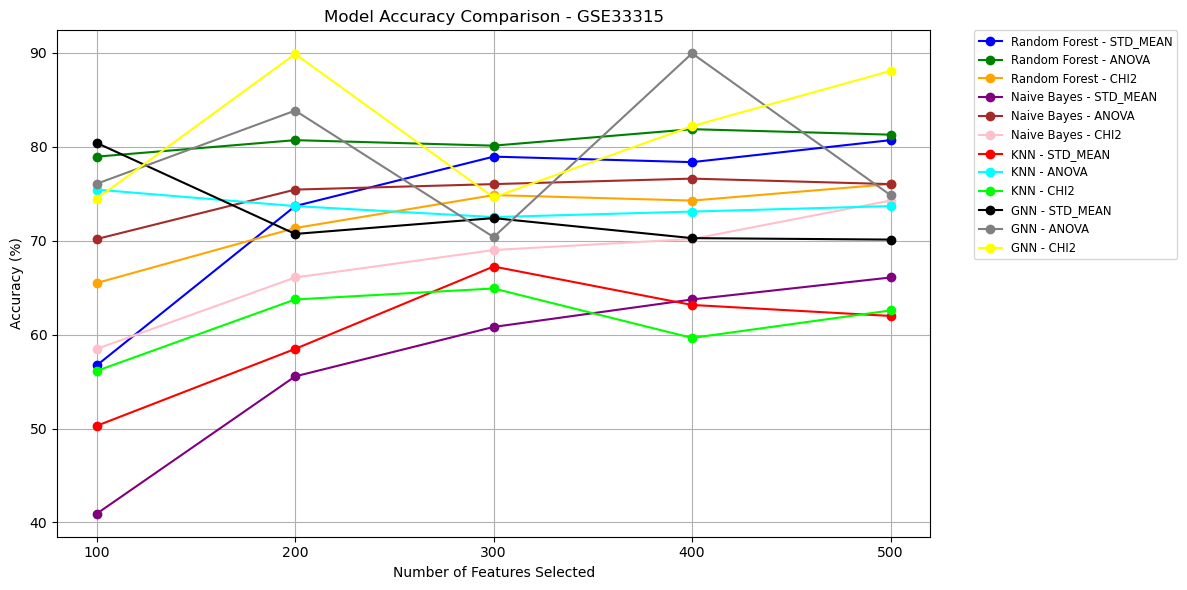

In [6]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


# Helper Function to Save Results
def save_results_to_csv(results, output_file):
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_file, index=False)
    print(f"Results saved to {output_file}")


def plot_results(results_file, datasets, k_values):
    results_df = pd.read_csv(results_file)

    colors = {
        "Random Forest": {"STD_MEAN": "blue", "ANOVA": "green", "CHI2": "orange"},
        "Naive Bayes": {"STD_MEAN": "purple", "ANOVA": "brown", "CHI2": "pink"},
        "KNN": {"STD_MEAN": "red", "ANOVA": "cyan", "CHI2": "lime"},
        "GNN": {"STD_MEAN": "black", "ANOVA": "gray", "CHI2": "yellow"},
    }

    for dataset in datasets:
        dataset_results = results_df[results_df["Dataset"] == dataset]
        plt.figure(figsize=(12, 6))

        for model in dataset_results["Model"].unique():
            model_results = dataset_results[dataset_results["Model"] == model]
            for method in model_results["Method"].unique():
                method_results = model_results[model_results["Method"] == method]
                plt.plot(
                    method_results["Feature Count"],
                    method_results["Accuracy"] * 100,  # Convert to percentage
                    marker='o',
                    label=f"{model} - {method}",
                    color=colors[model][method.upper()]
                )

        plt.title(f"Model Accuracy Comparison - {dataset}")
        plt.xlabel("Number of Features Selected")
        plt.ylabel("Accuracy (%)")
        plt.xticks(k_values)
        plt.grid()

        # Place the legend outside the plot
        plt.legend(
            loc="upper left",
            bbox_to_anchor=(1.05, 1),
            borderaxespad=0,
            fontsize="small"
        )
        plt.tight_layout()  # Adjust layout to fit legend
        plt.show()
    
# Random Forest Pipeline
def random_forest_pipeline_for_selected_features(datasets, target_column="Target", n_estimators=100, test_size=0.3, random_state=42, k_values=None, methods=None, output_dir="preprocessed/selected_features", results=[]):
    if k_values is None:
        k_values = [100, 200, 300, 400, 500]
    if methods is None:
        methods = ["std_mean", "anova", "chi2"]

    for dataset in datasets:
        dataset_name = dataset.split("/")[-1]
        for method in methods:
            for k in k_values:
                selected_features_file = f"{output_dir}/{dataset_name}_{method}_k{k}_selected.csv"
                if not os.path.exists(selected_features_file):
                    print(f"File not found: {selected_features_file}. Skipping...")
                    continue

                data = pd.read_csv(selected_features_file)
                X = data.drop(columns=[target_column])
                y = data[target_column]
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)

                rf = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
                rf.fit(X_train, y_train)
                y_pred = rf.predict(X_test)

                accuracy = accuracy_score(y_test, y_pred)
                results.append({
                    "Dataset": dataset_name,
                    "Method": method.upper(),
                    "Feature Count": k,
                    "Model": "Random Forest",
                    "Accuracy": accuracy
                })


# Naive Bayes Pipeline
def naive_bayes_pipeline_for_selected_features(datasets, target_column="Target", test_size=0.3, random_state=42, k_values=None, methods=None, output_dir="preprocessed/selected_features", results=[]):
    if k_values is None:
        k_values = [100, 200, 300, 400, 500]
    if methods is None:
        methods = ["std_mean", "anova", "chi2"]

    for dataset in datasets:
        dataset_name = dataset.split("/")[-1]
        for method in methods:
            for k in k_values:
                selected_features_file = f"{output_dir}/{dataset_name}_{method}_k{k}_selected.csv"
                if not os.path.exists(selected_features_file):
                    print(f"File not found: {selected_features_file}. Skipping...")
                    continue

                data = pd.read_csv(selected_features_file)
                X = data.drop(columns=[target_column])
                y = data[target_column]
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)

                nb = GaussianNB()
                nb.fit(X_train, y_train)
                y_pred = nb.predict(X_test)

                accuracy = accuracy_score(y_test, y_pred)
                results.append({
                    "Dataset": dataset_name,
                    "Method": method.upper(),
                    "Feature Count": k,
                    "Model": "Naive Bayes",
                    "Accuracy": accuracy
                })


# KNN Pipeline
def knn_pipeline_for_selected_features(datasets, target_column="Target", k_neighbors=5, test_size=0.3, random_state=42, k_values=None, methods=None, output_dir="preprocessed/selected_features", results=[]):
    if k_values is None:
        k_values = [100, 200, 300, 400, 500]
    if methods is None:
        methods = ["std_mean", "anova", "chi2"]

    for dataset in datasets:
        dataset_name = dataset.split("/")[-1]
        for method in methods:
            for k in k_values:
                selected_features_file = f"{output_dir}/{dataset_name}_{method}_k{k}_selected.csv"
                if not os.path.exists(selected_features_file):
                    print(f"File not found: {selected_features_file}. Skipping...")
                    continue

                data = pd.read_csv(selected_features_file)
                X = data.drop(columns=[target_column])
                y = data[target_column]
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)

                knn = KNeighborsClassifier(n_neighbors=k_neighbors)
                knn.fit(X_train, y_train)
                y_pred = knn.predict(X_test)

                accuracy = accuracy_score(y_test, y_pred)
                results.append({
                    "Dataset": dataset_name,
                    "Method": method.upper(),
                    "Feature Count": k,
                    "Model": "KNN",
                    "Accuracy": accuracy
                })


# Main Script
if __name__ == "__main__":
    datasets = [
        "GSE27562",
        "GSE19804",
        "GSE4290",
        "GSE59856",
        "GSE33315"
    ]
    target_column = "Target"
    output_dir = "preprocessed/selected_features"

    results = []  # Shared results list

    # Run all models
    random_forest_pipeline_for_selected_features(datasets, target_column, results=results, output_dir=output_dir)
    naive_bayes_pipeline_for_selected_features(datasets, target_column, results=results, output_dir=output_dir)
    knn_pipeline_for_selected_features(datasets, target_column, results=results, output_dir=output_dir)
    gnn_pipeline_for_selected_features(datasets, target_column, results=results, output_dir=output_dir)

    # Save results to CSV
    results_file = "model_results.csv"
    save_results_to_csv(results, results_file)

    # Generate comparison graphs
    k_values = [100, 200, 300, 400, 500]
    plot_results(results_file, datasets, k_values)
